In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [33]:
seasons = [
    '00_01', '01_02', '02_03', '03_04', '04_05',
    '05_06', '06_07', '07_08', '08_09', '09_10',
    '10_11', '11_12', '12_13', '13_14', '14_15',
    '15_16', '16_17', '17_18', '18_19', '19_20',
    '20_21', '21_22', '22_23', '23_24'
]

columns = [
    "Div", "Date", "HomeTeam", "AwayTeam",
    "FTHG", "FTAG", "FTR",
    "HTHG", "HTAG", "HTR", "HS", "AS", "HST",
    "AST", "HHW", "AHW", "HC", "AC", "HF", "AF",
    "HFKC", "AFKC", "HO", "AO", "HY", "AY", "HR", "AR"
]

df = pd.DataFrame(columns=columns)

for season in seasons:
    season_df = pd.read_csv(f'../00_data/00_statistical_data/{season}/E0.csv')
    season_df = season_df[[col for col in columns if col in season_df.columns]]
    df = pd.concat([df, season_df], ignore_index=True)

df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HF,AF,HFKC,AFKC,HO,AO,HY,AY,HR,AR
0,E0,19/08/00,Charlton,Man City,4,0,H,2,0,H,...,13,12,NaN,NaN,8,6,1,2,0,0
1,E0,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,...,19,14,NaN,NaN,2,3,1,2,0,0
2,E0,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,...,15,21,NaN,NaN,1,3,5,3,1,0
3,E0,19/08/00,Derby,Southampton,2,2,D,1,2,A,...,11,13,NaN,NaN,0,2,1,1,0,0
4,E0,19/08/00,Leeds,Everton,2,0,H,2,0,H,...,21,20,NaN,NaN,6,1,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9116,E0,19/05/2024,Crystal Palace,Aston Villa,5,0,H,2,0,H,...,10,8,NaN,NaN,NaN,NaN,1,4,0,0
9117,E0,19/05/2024,Liverpool,Wolves,2,0,H,2,0,H,...,14,11,NaN,NaN,NaN,NaN,1,1,0,1
9118,E0,19/05/2024,Luton,Fulham,2,4,A,1,2,A,...,15,20,NaN,NaN,NaN,NaN,5,4,0,0
9119,E0,19/05/2024,Man City,West Ham,3,1,H,2,1,H,...,3,12,NaN,NaN,NaN,NaN,0,1,0,0


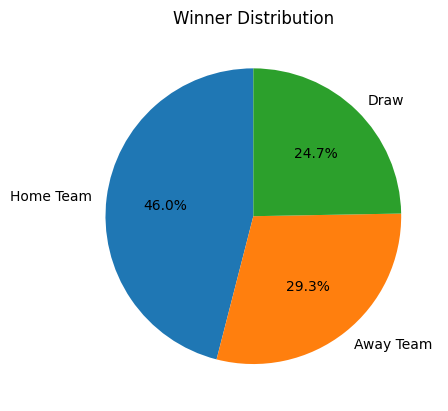

In [34]:
ftr_map = {'H': 'Home Team', 'D': 'Draw', 'A': 'Away Team'}
df['FTR'] = df['FTR'].map(ftr_map)
df['FTR'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)

plt.title('Winner Distribution')
plt.axis('off')
plt.show()

In [37]:
df.isna().sum()

Div            0
Date           0
HomeTeam       0
AwayTeam       0
FTHG           0
FTAG           0
FTR            0
HTHG           0
HTAG           0
HTR            0
HS             0
AS             0
HST            0
AST            0
HHW         8360
AHW         8360
HC             0
AC             0
HF             0
AF             0
HFKC        9120
AFKC        9120
HO          8360
AO          8360
HY             0
AY             0
HR             0
AR             0
dtype: int64

In [36]:
df = df.dropna(subset=['Div'])

In [40]:
def calculate_team_mean(df, team, cutoff_date, metric):
    
    cutoff_date = pd.Timestamp(cutoff_date)
    
    df_filtered = df[
    ((df["HomeTeam"] == team) | (df["AwayTeam"] == team)) & (df['Date'] < cutoff_date)
    ].sort_values('Date', ascending=False).head(5)
    
    if df_filtered.empty:
        return None
    
    mean = df_filtered.apply(
        lambda row: row[metric] if row["HomeTeam"] == team 
        else row["H" + metric[1:].replace("H", "A")], 
        axis=1
    ).mean()

    return mean

def calculate_points(df, team, cutoff_date):
    
    cutoff_date = pd.Timestamp(cutoff_date)
    
    df_filtered = df[
        ((df["HomeTeam"] == team) | (df["AwayTeam"] == team)) & (df['Date'] < cutoff_date)
    ].sort_values('Date', ascending=False).head(5)
    
    if df_filtered.empty:
        return None
    
    points = df_filtered.apply(
        lambda row: (
            3 if (row["HomeTeam"] == team and row["FTR"] == "H") or 
                 (row["AwayTeam"] == team and row["FTR"] == "A")
            else 1 if row["FTR"] == "D"
            else 0
        ), 
        axis=1
    ).mean()

    return points

# Main pipeline
metrics_map = {
    'FTHG': 'FullTimeGoals',
    'HTHG': 'HalfTimeGoals',
    'HS': 'Shots',
    'HST': 'ShotsOnTarget',
    'HW': 'HitWoodwork',
    'HC': 'Corners',
    'HF': 'Fouls',
    'HFKC': 'FreeKicksConceded',
    'HO': 'Offsides',
    'HY': 'YellowCards',
    'HR': 'RedCards'
}

cols_to_leave = [
    'Date', 'HomeTeam', 'AwayTeam',
    'FTR', 'FTHG', 'FTAG',
    'HTHG', 'HTAG',
    'HS', 'AS',
    'HST', 'AST',
    'HC', 'AC',
    'HF', 'AF',
    'HY', 'AY'
]

metrics = ['FTHG', 'HS', 'HST', 'HC', 'HF', 'HY']
# seasons = ['22_23', '23_24']
df_list = []

for season in seasons:
    # Load and preprocess data
    df = pd.read_csv(f'../00_data/00_statistical_data/{season}/E0.csv')
    df = df.dropna(subset=['Div'])
    df = df[cols_to_leave]

    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    except ValueError:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')    
    
    teams = set(df['HomeTeam']).union(set(df['AwayTeam']))
    for team in teams:
        subset = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        dates = subset['Date'].unique()
        for date in dates:
            # Calculate mean statistics for each metric
            for metric in metrics:
                mean = calculate_team_mean(df, team, date, metric)
                if mean is not None:
                    if subset[subset['Date'] == date]['HomeTeam'].values[0] == team:
                        df.loc[(df['HomeTeam'] == team) & (df['Date'] == date), f'HomeTeam_{metrics_map[metric]}_mean'] = mean
                    else:
                        df.loc[(df['AwayTeam'] == team) & (df['Date'] == date), f'AwayTeam_{metrics_map[metric]}_mean'] = mean

            # Calculate points for the team
            points = calculate_points(df, team, date)
            if points is not None:
                if subset[subset['Date'] == date]['HomeTeam'].values[0] == team:
                    df.loc[(df['HomeTeam'] == team) & (df['Date'] == date), 'HomeTeam_points'] = points
                else:
                    df.loc[(df['AwayTeam'] == team) & (df['Date'] == date), 'AwayTeam_points'] = points

        df_home = df[df['HomeTeam'] == team]
        df_away = df[df['AwayTeam'] == team]

        distr_home = df[df['HomeTeam'] == team]['FTR'].value_counts(normalize=True).to_dict()
        distr_away = df[df['AwayTeam'] == team]['FTR'].value_counts(normalize=True).to_dict()

        df_distr = pd.DataFrame(columns=['team', 'home', 'away'])

        df_distr = pd.concat([df_distr, pd.DataFrame({'team': team, 'home': [distr_home], 'away': [distr_away]})])
        df_distr['home_rate'] = df_distr['home'].apply(lambda x: 3 * x.get('H', 0) + x.get('D', 0))
        df_distr['away_rate'] = df_distr['away'].apply(lambda x: 3 * x.get('A', 0) + x.get('D', 0))

        try:
            df.loc[df['HomeTeam'] == team, 'HomeTeamRate'] = df_distr[df_distr['team'] == team]['home_rate'].values[0]
        except:
            print(f'Error for {team} in season {season}')
        
        try:
            df.loc[df['AwayTeam'] == team, 'AwayTeamRate'] = df_distr[df_distr['team'] == team]['away_rate'].values[0]
        except:
            print(f'Error for {team} in season {season}')
                    
    df_list.append(df)

# Combine data for all seasons
df = pd.concat(df_list)

df['season'] = df['Date'].apply(lambda x: x.year if x.month < 7 else x.year + 1)

df['HomeTeamRate'] = df.groupby(['HomeTeam', 'season'])['HomeTeamRate'].shift(1)
df['AwayTeamRate'] = df.groupby(['AwayTeam', 'season'])['AwayTeamRate'].shift(1)

df

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HTHG,HTAG,HS,AS,...,HomeTeam_FullTimeGoals_mean,HomeTeam_Shots_mean,HomeTeam_ShotsOnTarget_mean,HomeTeam_Corners_mean,HomeTeam_Fouls_mean,HomeTeam_YellowCards_mean,HomeTeam_points,HomeTeamRate,AwayTeamRate,season
0,2000-08-19,Charlton,Man City,H,4.0,0.0,2.0,0.0,17.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001
1,2000-08-19,Chelsea,West Ham,H,4.0,2.0,1.0,0.0,17.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001
2,2000-08-19,Coventry,Middlesbrough,A,1.0,3.0,1.0,1.0,6.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001
3,2000-08-19,Derby,Southampton,D,2.0,2.0,1.0,2.0,6.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001
4,2000-08-19,Leeds,Everton,H,2.0,0.0,2.0,0.0,17.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2024-05-19,Crystal Palace,Aston Villa,H,5.0,0.0,2.0,0.0,15.0,8.0,...,2.6,15.6,6.6,6.0,11.0,2.0,2.6,1.473684,1.473684,2024
376,2024-05-19,Liverpool,Wolves,H,2.0,0.0,2.0,0.0,36.0,4.0,...,1.4,16.6,7.4,4.6,8.8,1.0,1.6,2.526316,1.000000,2024
377,2024-05-19,Luton,Fulham,A,2.0,4.0,1.0,2.0,15.0,15.0,...,0.6,18.8,6.8,7.0,11.4,1.4,0.2,0.842105,0.947368,2024
378,2024-05-19,Man City,West Ham,H,3.0,1.0,2.0,1.0,28.0,3.0,...,2.0,10.4,4.6,4.4,9.0,1.2,3.0,2.473684,1.210526,2024


In [41]:
df = df.reset_index(drop=True)
df.to_csv('../00_data/00_statistical_data/E0_processed.csv', index=False)